# Self-Driving Car Engineer Nanodegree

## Deep Learning Project: Build a Traffic Sign Recognition Classifier

In [9]:
import pickle
import seaborn as sns
import pandas as pd
import random
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

---
## Step 0: Load The Data

In [10]:
# Load pickled data

training_file = 'traffic-signs-data/train.p'
validation_file = 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [11]:
# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples
n_test = len(X_test)

# Shape of an traffic sign image
image_shape = X_train[0].shape

# Number of unique classes/labels there are in the dataset
classes = {}

for label in y_train:
    if not (label in classes):
        classes[label] = 0
    classes[label] += 1
n_classes = len(classes.keys())

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset


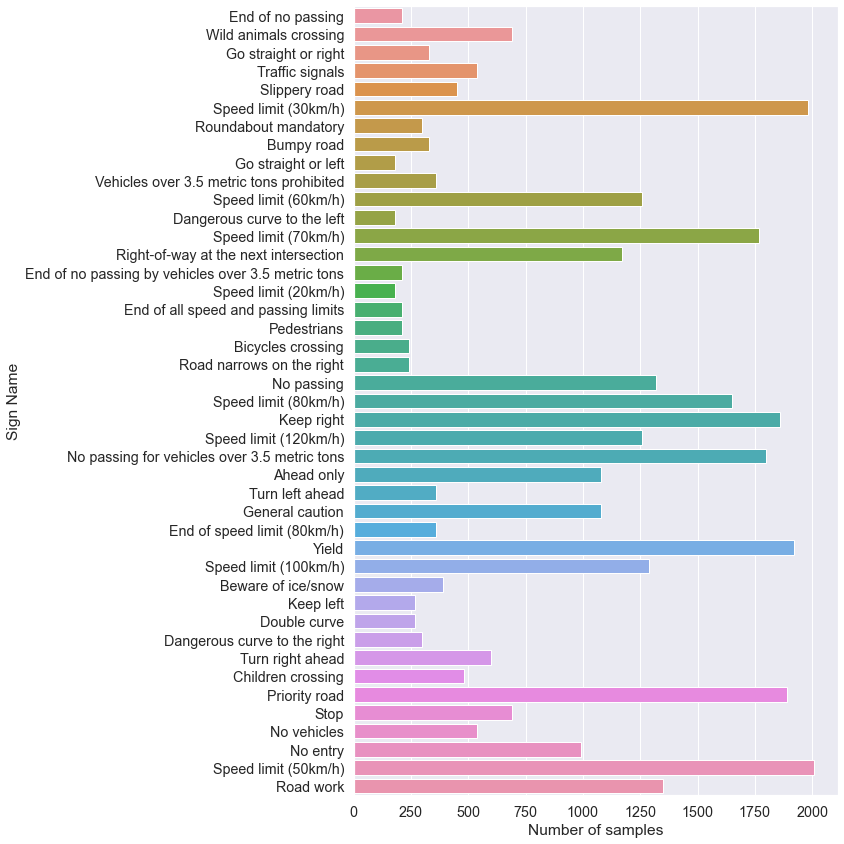

In [13]:
signnames = pd.read_csv('signnames.csv')
signnames.set_index('ClassId',inplace=True)

def get_name_from_label(label):
    return signnames.loc[label].SignName

counts = pd.DataFrame(columns=['sign_label','training_samples_count'],data=[(label, count) for label, count in classes.items()])
counts['sign'] = counts.sign_label.apply(get_name_from_label)

plt.figure(figsize=(12,12))
sns.set(font_scale=1.3)
sns.barplot(x='training_samples_count',y='sign',data=counts,orient='o')
plt.ylabel('Sign Name')
plt.xlabel('Number of samples')
plt.tight_layout()
plt.savefig('Assets/Visualize Dataset.png')

Speed limit (50km/h)


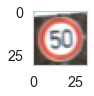

In [15]:
%matplotlib inline
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
sns.set_style("whitegrid", {'axes.grid' : False})
plt.imshow(image)
plt.savefig('Assets/Example.png')
print(get_name_from_label(y_train[index]))

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).


There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

### Pre-process the Data Set

The image data should be normalized so that the data has mean zero and equal variance.

In [16]:
def preprocessing(image):
    return image / 127.5 - 1

X_train = preprocessing(X_train)
X_valid = preprocessing(X_valid)
X_test = preprocessing(X_test)

X_train, y_train = shuffle(X_train, y_train)
EPOCHS = 20
BATCH_SIZE = 128

### Model Architecture


In [17]:
def LeNet(x):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1


    # TODO: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # TODO: Activation.
    conv1 = tf.nn.relu(conv1)

    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    # TODO: Activation.
    conv2 = tf.nn.relu(conv2)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    fc0 = flatten(conv2)
    dr0 = tf.nn.dropout(fc0, keep_prob)

    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(dr0, fc1_W) + fc1_b

    # TODO: Activation.
    fc1 = tf.nn.relu(fc1)
    dr1 = tf.nn.dropout(fc1, keep_prob)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(dr1, fc2_W) + fc2_b

    # TODO: Activation.
    fc2 = tf.nn.relu(fc2)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b

    return (logits, conv1, conv2, fc1, fc2)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [18]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)

rate = 0.001

logits, conv1, conv2, fc1, fc2 = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")
    print()
    validation_accuracy = 0
    i = 0
    while(validation_accuracy < 0.965):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples,  BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.7})

        previous_accuracy = validation_accuracy
        validation_accuracy = evaluate(X_valid, y_valid)
        if previous_accuracy > validation_accuracy:
            rate *= 0.8
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {0:1.1%}".format(validation_accuracy))
        print()
        i += 1

    saver.save(sess, './lenet')
    print("Model saved")

In [19]:
with tf.Session() as sess:
  saver.restore(sess, './lenet')
  print('Model Accuracy On Training Images: {0:1.1%}'.format(evaluate(X_train, y_train)))
  print('Model Accuracy On Validation Images: {0:1.1%}'.format(evaluate(X_valid, y_valid)))
  print('Model Accuracy On Test Images: {0:1.1%}'.format(evaluate(X_test, y_test)))

INFO:tensorflow:Restoring parameters from ./lenet
Model Accuracy On Training Images: 99.8%
Model Accuracy On Validation Images: 96.8%
Model Accuracy On Test Images: 95.3%


---

## Step 3: Test a Model on New Images

To give more insight into how the model is working, five pictures of German traffic signs were downloaded from the web. The model was used to predict the traffic sign type.

### Load and Output the Images

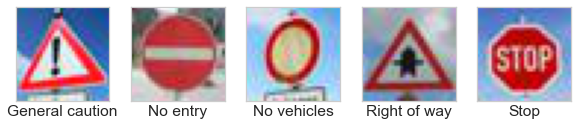

In [20]:
files = os.listdir("Examples/")
plt.figure(figsize=(10,10))
i=1

for file in files:
    image = mpimg.imread('Examples/' + file)
    plt.subplot(5,5,i)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(file[int(i/10)+2:len(file)-4])
    i+=1

### Analyze Performance

In [21]:
import numpy as np
examples_labels_backup = [18, 17, 15, 11, 14]
examples_labels = [18, 17, 15, 11, 14]

examples_data = []
for file in files:
    image = mpimg.imread('Examples/' + file)
    examples_data.append (image)

examples_data = np.array(examples_data)
examples_data = examples_data / 127.5 - 1

print('examples_data shape:', np.array(examples_data).shape)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(""))
    examples_softmax = sess.run(tf.nn.softmax(logits), feed_dict={x: examples_data, keep_prob: 1.0})
    predicts = sess.run(tf.nn.top_k(examples_softmax, k=5, sorted=True))
    print('Model Accuracy On New Images: {0:1.0%}'.format(evaluate(examples_data, examples_labels)))

examples_data shape: (5, 32, 32, 3)
INFO:tensorflow:Restoring parameters from lenet
Model Accuracy On New Images: 100%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [22]:
probabilities, signs = predicts[0], predicts[1]

for i in range(len(signs)):
    print('\n', 'Image', i, 'Correct answer: ', files[i][2:len(files[i])-4])
    for j in range(len(signs[i])):
        print(get_name_from_label(signs[i][j]) + ': ' + '{0:1.1%}'.format(probabilities[i][j]))


 Image 0 Correct answer:  General caution
General caution: 95.4%
Bumpy road: 4.5%
Bicycles crossing: 0.1%
Road narrows on the right: 0.0%
Pedestrians: 0.0%

 Image 1 Correct answer:  No entry
No entry: 100.0%
Speed limit (20km/h): 0.0%
Stop: 0.0%
Speed limit (30km/h): 0.0%
Traffic signals: 0.0%

 Image 2 Correct answer:  No vehicles
No vehicles: 100.0%
No passing: 0.0%
Yield: 0.0%
Speed limit (120km/h): 0.0%
Speed limit (30km/h): 0.0%

 Image 3 Correct answer:  Right of way
Right-of-way at the next intersection: 100.0%
Beware of ice/snow: 0.0%
Slippery road: 0.0%
Children crossing: 0.0%
Double curve: 0.0%

 Image 4 Correct answer:  Stop
Stop: 100.0%
No entry: 0.0%
Speed limit (20km/h): 0.0%
Speed limit (80km/h): 0.0%
Bicycles crossing: 0.0%


---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images


In [23]:
# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")


INFO:tensorflow:Restoring parameters from ./lenet
conv1 : First layer


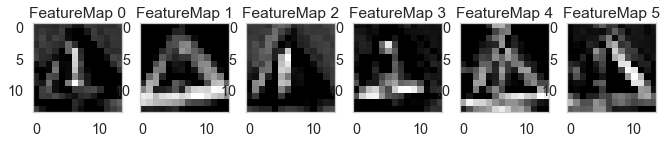

In [26]:
with tf.Session() as sess:
    saver.restore(sess, './lenet')
    print("conv1 : First layer")
    outputFeatureMap(examples_data, conv1)

INFO:tensorflow:Restoring parameters from ./lenet
conv2 : Second layer


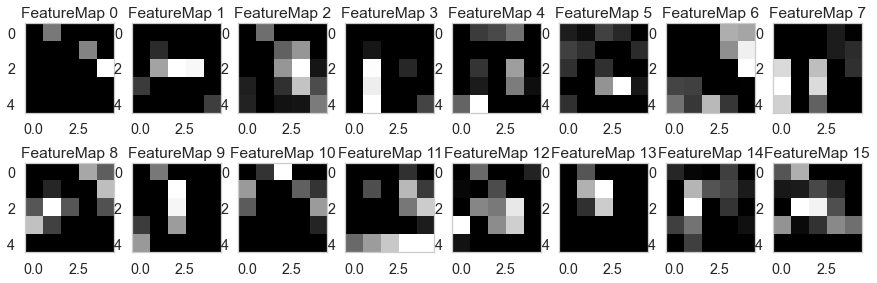

In [25]:
with tf.Session() as sess:
    saver.restore(sess, './lenet')
    print("conv2 : Second layer")
    outputFeatureMap(examples_data, conv2)